In [1]:
import os
import pandas as pd

In [3]:
## Subset to lesion types of interest
info = pd.read_csv("DL_info.csv")
info = info[info['Coarse_lesion_type'].isin([4,5, 6])]
info.head()

,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test
15,000004_02_02_073.png,4,2,2,73,"304.164, 243.128, 296.741, 240.653, 301.69, 23...","291.741, 234.828, 309.164, 250.602","7.82493, 6.08608","0.576805, 0.502328, 0.408573",5,0,"43, 103","0.585938, 0.585938, 1","512, 512","-1500, 500",F,20.0,2
16,000004_02_02_145.png,4,2,2,145,"427.063, 184.565, 427.063, 169.719, 433.661, 1...","413.814, 164.719, 438.661, 189.565","14.8468, 14.8467","0.8304, 0.412889, 0.527688",5,0,"115, 175","0.585938, 0.585938, 1","512, 512","-1500, 500",F,20.0,2
18,000004_03_02_136.png,4,3,2,136,"375.569, 243.103, 381.134, 255.946, 384.559, 2...","368, 238.103, 389.559, 260.946","13.9968, 12.5971","0.826738, 0.417789, 0.515763",5,0,"106, 166","0.703125, 0.703125, 1","512, 512","-1500, 500",F,20.0,2
36,000009_04_02_022.png,9,4,2,22,"361.919, 302.905, 327.575, 286.942, 348.375, 2...","322.575, 273.719, 366.919, 307.905","37.8727, 24.0038","0.663176, 0.627188, 0.456856",5,0,"16, 28","0.78125, 0.78125, 5","512, 512","-175, 275",M,58.0,2
38,000009_04_03_101.png,9,4,3,101,"358.573, 305.644, 322.358, 285.447, 332.108, 3...","317.358, 274.875, 363.573, 310.644","41.4659, 28.7072","0.654828, 0.630702, 0.455769",5,0,"71, 131","0.78125, 0.78125, 1","512, 512","-1500, 500",M,58.0,2


In [69]:
## Remove all images that are not of interest
for filename in os.listdir('Key_slices'):
    if not info['File_name'].str.contains(filename).any():
        os.remove('Key_slices/'+filename)

In [75]:
## Create Test Train Split
import numpy as np
info['splits'] = np.random.choice([0,1,2], size=len(info.File_name), p = (0.6,0.2,0.2))

In [76]:
## Bounding box calc for yolov5 format
x1,y1,x2,y2 = (info.Bounding_boxes.str.split(",").str[i].astype(float) for i in range(4))
xc = round((x1 + x2) / (2 * 512), 3)
yc = round((y1 + y2) / (2 * 512), 3)
xr = round(abs(x1 - x2) / 512, 3)
yr = round(abs(y1 - y2) / 512, 3)
xc,yc,xr,yr = xc.astype(str), yc.astype(str), xr.astype(str), yr.astype(str)
info['target'] = "0 " + xc + " " + yc + " " + xr + " " + yr

In [ ]:
## Make Directories to save images
os.makedirs('images/test', exist_ok=False)
os.makedirs('images/train', exist_ok=False)
os.makedirs('images/val', exist_ok=False)
os.makedirs('labels/test', exist_ok=False)
os.makedirs('labels/train', exist_ok=False)
os.makedirs('labels/val', exist_ok=False)

In [107]:
os.makedirs('images16/test', exist_ok=False)
os.makedirs('images16/train', exist_ok=False)
os.makedirs('images16/val', exist_ok=False)
os.makedirs('images64/test', exist_ok=False)
os.makedirs('images64/train', exist_ok=False)
os.makedirs('images64/val', exist_ok=False)
os.makedirs('images128/test', exist_ok=False)
os.makedirs('images128/train', exist_ok=False)
os.makedirs('images128/val', exist_ok=False)

In [78]:
## Split and save train, val and test iamges in appropriate folders
trainData = info[info['splits'].isin([0])]
valData = info[info['splits'].isin([1])]
testData = info[info['splits'].isin([2])]
for image in trainData['File_name']:
    if os.path.exists('Key_slices/'+image):
        os.rename('Key_slices/'+image, 'images/train/'+image)
for image in valData['File_name']:
    if os.path.exists('Key_slices/'+image):
        os.rename('Key_slices/'+image, 'images/val/'+image)
for image in testData['File_name']:
    if os.path.exists('Key_slices/'+image):
        os.rename('Key_slices/'+image, 'images/test/'+image)

In [113]:
## Create Labels for each which contain bounding boxes
for name in os.listdir('images/train'):
    sample = info[info['File_name'] == name].iloc[0]
    f= open('labels/train/'+sample['File_name'].split('.')[0]+'.txt',"w+")
    f.write(sample['target'])
    f.close()
for name in os.listdir('images/val'):
    sample = info[info['File_name'] == name].iloc[0]
    f= open('labels/val/'+sample['File_name'].split('.')[0]+'.txt',"w+")
    f.write(sample['target'])
    f.close()
for name in os.listdir('images/test'):
    sample = info[info['File_name'] == name].iloc[0]
    f= open('labels/test/'+sample['File_name'].split('.')[0]+'.txt',"w+")
    f.write(sample['target'])
    f.close()

C:\ProgramData\Miniconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


0.0010972999998557498


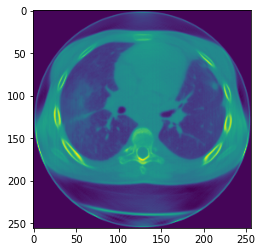

In [80]:
## Demonstrate sinogram reconstruction with views
from PIL import Image
import timeit
from skimage.transform import radon, iradon_sart
import matplotlib.pyplot as plt
instances = []

for filepath in os.listdir('images/train'):
    im = Image.open('images/train' + '/{0}'.format(filepath))
    instances.append(np.asarray(im, dtype=int))

n_views = 128
start = timeit.timeit()
for x in range(0, 10):
  x1 = instances[0]
  x1 = x1 - np.min(x1)
  theta = np.linspace(0., 180., n_views, endpoint=False)
  x1_sino = radon(x1, theta=theta)
  x1_recons = iradon_sart(x1_sino, theta=theta)
end = timeit.timeit()
print(end - start)

plt.imshow(x1_recons)

In [ ]:
def getReconstruction(x1, n_views):
    x1 = x1 - np.min(x1)
    theta = np.linspace(0., 180., n_views, endpoint=False)
    x1_sino = radon(x1, theta=theta)
    x1_recons = iradon_sart(x1_sino, theta=theta)
    return x1_recons
## Create images based on 16 views and save them
for filepath in os.listdir('images/train'):
    im = Image.open('images/train' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images16/train' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 16))
for filepath in os.listdir('images/val'):
    im = Image.open('images/val' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images16/val' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 16))
for filepath in os.listdir('images/test'):
    im = Image.open('images/test' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images16/test' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 16))

In [ ]:
## Create images based on 64 views and save them
for filepath in os.listdir('images/train'):
    im = Image.open('images/train' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images64/train' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 64))
for filepath in os.listdir('images/val'):
    im = Image.open('images/val' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images64/val' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 64))
for filepath in os.listdir('images/test'):
    im = Image.open('images/test' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images64/test' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 64))

In [ ]:
## Create images based on 128 views and save them
for filepath in os.listdir('images/train'):
    im = Image.open('images/train' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images128/train' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 128))
for filepath in os.listdir('images/val'):
    im = Image.open('images/val' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images128/val' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 128))
for filepath in os.listdir('images/test'):
    im = Image.open('images/test' + '/{0}'.format(filepath))
    im = im.resize((128,128))
    plt.imsave('images128/test' + '/{0}'.format(filepath), getReconstruction(np.asarray(im, dtype=int), 128))

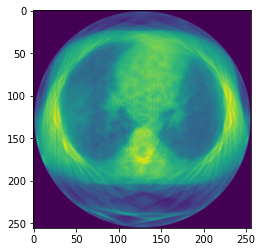

In [101]:
n_views = 16
x1 = getReconstruction(Image.open('images/train/000004_02_02_145.png'), 16)
# x1 = x1 - np.min(x1)
# theta = np.linspace(0., 180., n_views, endpoint=False)
# x1_sino = radon(x1, theta=theta)
# x1_recons = iradon_sart(x1_sino, theta=theta)
plt.imshow(x1)
plt.imsave('images16/train' + '/{0}'.format('000004_02_02_145.png'), x1)